<img src="https://images.unsplash.com/photo-1533709752211-118fcaf03312?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80" width=400%>


<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 013</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">roberta-base</li>
    <li style = "color:#4c1c84;
                font-size:14px">過去コンペの復習</li>
    <li style = "color:#4c1c84;
                font-size:14px">BCEWithLogitsLoss</li>

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install japanize_matplotlib -q
!pip install wandb -q
!pip install pytorch_lightning -Uq
!pip install transformers -Uq
!pip install python-box -Uq
!pip install rich -Uq

     |████████████████████████████████| 4.1 MB 15.5 MB/s 
     |████████████████████████████████| 1.7 MB 14.9 MB/s 
     |████████████████████████████████| 180 kB 83.7 MB/s 
     |████████████████████████████████| 140 kB 83.0 MB/s 
     |████████████████████████████████| 97 kB 8.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 525 kB 15.4 MB/s 
     |████████████████████████████████| 596 kB 62.2 MB/s 
     |████████████████████████████████| 132 kB 85.9 MB/s 
     |████████████████████████████████| 829 kB 54.0 MB/s 
     |████████████████████████████████| 332 kB 65.8 MB/s 
     |████████████████████████████████| 1.1 MB 53.3 MB/s 
     |████████████████████████████████| 160 kB 72.5 MB/s 
     |████████████████████████████████| 271 kB 70.3 MB/s 
     |████████████████████████████████| 192 kB 69.6 MB/s 
     |████████████████████████████████| 3.4 MB 12.8 MB/s 
     |████████████████████████████████| 895 kB 76.8 MB/s 
     |████████████

## Libraries

In [ ]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import RobertaModel
from transformers import RobertaTokenizer

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

# Model
import lightgbm as lgb

In [ ]:
import torch

config = {
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 256,
    "environment": "Colab",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "012_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 64,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": False,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 16,
        "shuffle": False,
        "num_workers": 4,
        "pin_memory": True,
        "drop_last": False,
    },

    "valid_loader": {
        "batch_size": 4,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "unitary/unbiased-toxic-roberta",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-5,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.BCEWithLogitsLoss",
}

config = Box(config)
config.tokenizer = RobertaTokenizer.from_pretrained(config.backbone.name)
config.model = RobertaModel.from_pretrained(config.backbone.name)
pprint(config)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/997 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/unbiased-toxic-roberta were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at unitary/unbiased-toxic-roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'backbone': <Box: {'name': 'unitary/unbiased-toxic-roberta', 'output_dim': 1}>,
 'entity': 'dataskywalker',
 'environment': 'Colab',
 'epoch': 5,
 'exp_name': '012_exp',
 'loss': 'nn.BCEWithLogitsLoss',
 'margin': 0.5,
 'max_length': 256,
 'model': RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0

In [ ]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'Colab'.
INPUT_DIR is /content/drive/MyDrive/kaggle/Jigsaw/raw
MODEL_DIR is /content/drive/MyDrive/kaggle/Jigsaw/interim/012_exp
OUTPUT_DIR is /content/drive/MyDrive/kaggle/Jigsaw/interim/012_exp


In [ ]:
# Seed固定
seed_everything(config.seed)

Global seed set to 42


42

In [ ]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

# Data Load

In [ ]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/content/drive/MyDrive/kaggle/Jigsaw/raw/comments_to_score.csv
/content/drive/MyDrive/kaggle/Jigsaw/raw/validation_data.csv
/content/drive/MyDrive/kaggle/Jigsaw/raw/sample_submission.csv


In [ ]:
## Data Check
TRAIN_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/exterim")
for dirnames, _, filenames in os.walk(TRAIN_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/content/drive/MyDrive/kaggle/Jigsaw/exterim/all_data.csv
/content/drive/MyDrive/kaggle/Jigsaw/exterim/identity_individual_annotations.csv
/content/drive/MyDrive/kaggle/Jigsaw/exterim/sample_submission.csv
/content/drive/MyDrive/kaggle/Jigsaw/exterim/test.csv
/content/drive/MyDrive/kaggle/Jigsaw/exterim/test_private_expanded.csv
/content/drive/MyDrive/kaggle/Jigsaw/exterim/test_public_expanded.csv
/content/drive/MyDrive/kaggle/Jigsaw/exterim/toxicity_individual_annotations.csv
/content/drive/MyDrive/kaggle/Jigsaw/exterim/train.csv


In [ ]:
train_df = pd.read_csv(TRAIN_DIR/"train.csv")
val_df = pd.read_csv(INPUT_DIR/"validation_data.csv")
toxic_anno_df = pd.read_csv(TRAIN_DIR/"toxicity_individual_annotations.csv")

validation_feature = np.load(OUTPUT_DIR/"valid_feature.npy")
display(train_df.head())
display(val_df.head())
display(toxic_anno_df.head())
display(validation_feature.shape)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,id,worker,toxic,severe_toxic,identity_attack,insult,obscene,sexual_explicit,threat
0,59859,0,1,0,0,1,1,0,0
1,59859,1,1,0,0,0,1,0,0
2,59859,2,1,0,0,1,1,0,0
3,59859,3,1,1,0,0,1,0,0
4,59859,4,1,0,0,0,1,0,0


(8959, 768)

# EDA

In [ ]:
toxic_anno_df["id"].value_counts()

5118044    4936
5380193    4897
5292392    4177
5481314    3623
5588434    3523
           ... 
435840        3
865813        3
454381        3
857397        3
5445443       3
Name: id, Length: 1804874, dtype: int64

In [ ]:
tmp_id = 59859
display(toxic_anno_df[toxic_anno_df["id"]==tmp_id]["toxic"].value_counts())
print(toxic_anno_df[toxic_anno_df["id"]==tmp_id]["toxic"].agg("mean"))
display(train_df[train_df["id"]==tmp_id]["target"])

1    70
0    35
Name: toxic, dtype: int64

0.6666666666666666


5    0.666667
Name: target, dtype: float64

In [ ]:
for tmp_id in toxic_anno_df["id"].unique().tolist()[:20]:

    anno_mean = toxic_anno_df[toxic_anno_df["id"]==tmp_id]["toxic"].agg("mean")
    target = train_df[train_df["id"]==tmp_id]["target"].values[0]

    print(f"{tmp_id:06d} | Annotator Mean: {anno_mean:.3f} | Target: {target:.3f}")

059859 | Annotator Mean: 0.667 | Target: 0.667
239576 | Annotator Mean: 0.000 | Target: 0.000
239579 | Annotator Mean: 0.440 | Target: 0.440
239607 | Annotator Mean: 0.912 | Target: 0.912
239611 | Annotator Mean: 0.000 | Target: 0.000
239617 | Annotator Mean: 0.000 | Target: 0.000
239626 | Annotator Mean: 0.000 | Target: 0.000
239636 | Annotator Mean: 0.000 | Target: 0.000
239655 | Annotator Mean: 0.361 | Target: 0.361
239669 | Annotator Mean: 0.000 | Target: 0.000
239683 | Annotator Mean: 0.000 | Target: 0.000
239722 | Annotator Mean: 0.000 | Target: 0.000
239724 | Annotator Mean: 0.000 | Target: 0.000
239726 | Annotator Mean: 0.000 | Target: 0.000
239733 | Annotator Mean: 0.000 | Target: 0.000
239747 | Annotator Mean: 0.000 | Target: 0.000
239781 | Annotator Mean: 0.000 | Target: 0.000
239787 | Annotator Mean: 0.200 | Target: 0.200
239793 | Annotator Mean: 0.000 | Target: 0.000
239796 | Annotator Mean: 0.000 | Target: 0.000


<br>
<li style = "font-size:14px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
trainデータの指標を基に学習をさせる
</li>
<li style = "font-size:14px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
validationデータはannotatorの割合をそのままtargetに
</li>
<br>

<br>
<h1 style = "font-size:60px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">Make Dataset</h1>
<br>

<br>
<h2 style = "font-size:60px; font-family:Comic Sans MS ; font-weight : normal; background-color: #eeebf1 ; color : #4c1c84; text-align: center; border-radius: 100px 100px;">Make Validation Data</h2>
<br>

In [ ]:
val_df.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


In [ ]:
whole_text = list(set(val_df["less_toxic"].unique().tolist())&set(val_df["more_toxic"].unique().tolist()))

validation_df = pd.DataFrame(columns=["id", "target", "comment_text"])
validation_df["comment_text"] = whole_text
validation_df["id"] = [i+1 for i in range(len(validation_df))]

target_list = []
for text in tqdm(whole_text, total=len(whole_text)):

    less_counts = val_df[val_df["less_toxic"]==text]["worker"].count()
    more_counts = val_df[val_df["more_toxic"]==text]["worker"].count()
    target = more_counts / (less_counts + more_counts)
    target_list.append(target)

validation_df["target"] = target_list
display(validation_df.head())

  0%|          | 0/8959 [00:00<?, ?it/s]

,id,target,comment_text
0,1,0.333333,"""\nOne night in an online coffee house, a self..."
1,2,0.500000,Declaration of war against vandalism on Marat...
2,3,0.333333,"""\nWell, you DID say on the incident page that..."
3,4,0.555556,ME! \n\nHouse of Scandal\ntries not give a ra...
4,5,0.833333,=================\nHey ! Are you member of no...


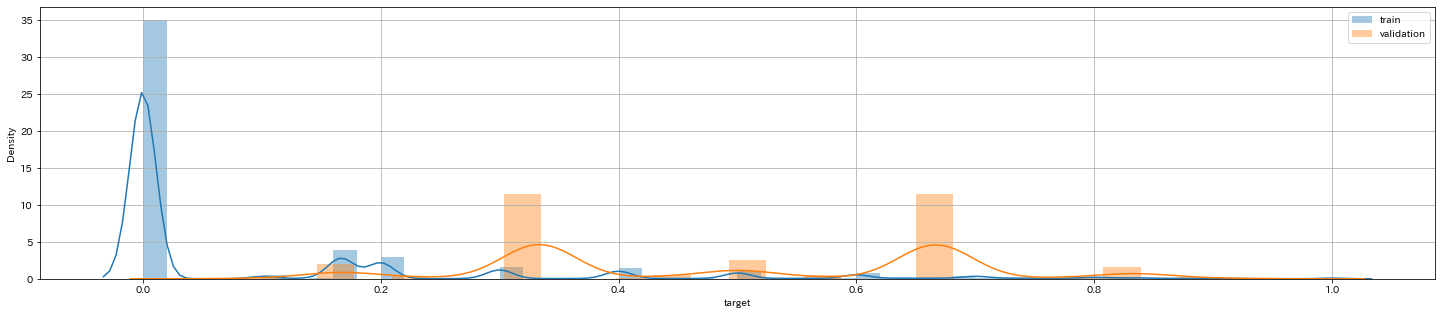

In [ ]:
plt.figure(figsize=(25, 5))
sns.distplot(train_df["target"], label="train")
sns.distplot(validation_df["target"], label="validation")
plt.grid()
plt.legend()
plt.show()

# LightGBM Training

- validation_feature(RoBERTa Toxicの768次元の特徴量) → validation_dfのtargetを予測　w/LightGBM

In [ ]:
validation_df.head()

,id,target,comment_text
0,1,0.333333,"""\nOne night in an online coffee house, a self..."
1,2,0.500000,Declaration of war against vandalism on Marat...
2,3,0.333333,"""\nWell, you DID say on the incident page that..."
3,4,0.555556,ME! \n\nHouse of Scandal\ntries not give a ra...
4,5,0.833333,=================\nHey ! Are you member of no...


In [ ]:
params = {
    "objective": "rmse", 
    "boosting_type": "gbdt",
    'learning_rate': 0.1,
    'num_leaves': 64,
    'verbosity': 0,
    'random_state': config.seed,
    'force_col_wise':True
}

In [ ]:
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
validation_df['bins'] = pd.cut(validation_df['target'], bins=20, labels=False)
oof = np.zeros(len(validation_df))

for fold, (tr_idx, va_idx) in enumerate(skf.split(validation_df, validation_df["bins"])):

    print(f'######################### Fold{fold+1} #############################')

    tr_fe = validation_feature[tr_idx]
    tr_ta = validation_df.loc[tr_idx, "target"]

    va_fe = validation_feature[va_idx]
    va_ta = validation_df.loc[va_idx, "target"]

    lgb_train = lgb.Dataset(tr_fe, tr_ta)
    lgb_eval = lgb.Dataset(va_fe, va_ta)

    lgb_model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            valid_names=[f'fold{fold+1}/train', f'fold{fold+1}/valid'],
            verbose_eval=100,
            num_boost_round=4000,
            early_stopping_rounds=100,
        )
    
    best_iter = lgb_model.best_iteration
    lgb_oof = lgb_model.predict(va_fe, num_iteration=best_iter)
    oof[va_idx] += lgb_oof

######################### Fold1 #############################
Training until validation scores don't improve for 100 rounds.
[100]	fold1/train's rmse: 0.0837081	fold1/valid's rmse: 0.204226
Early stopping, best iteration is:
[1]	fold1/train's rmse: 0.191172	fold1/valid's rmse: 0.19325
######################### Fold2 #############################
Training until validation scores don't improve for 100 rounds.
[100]	fold2/train's rmse: 0.0842669	fold2/valid's rmse: 0.201842
Early stopping, best iteration is:
[1]	fold2/train's rmse: 0.191055	fold2/valid's rmse: 0.193135
######################### Fold3 #############################
Training until validation scores don't improve for 100 rounds.
[100]	fold3/train's rmse: 0.0841909	fold3/valid's rmse: 0.201967
Early stopping, best iteration is:
[1]	fold3/train's rmse: 0.191163	fold3/valid's rmse: 0.193387
######################### Fold4 #############################
Training until validation scores don't improve for 100 rounds.
[100]	fold4/tra

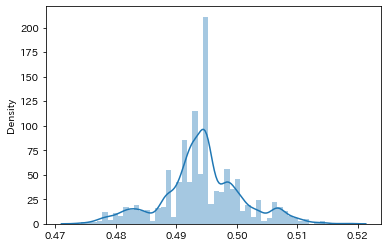

In [ ]:
sns.distplot(oof)

## Tokenizer & Model Save

In [ ]:
config.tokenizer.save_pretrained(OUTPUT_DIR/f"{config.backbone.name}")

pretrain_model = RobertaModel.from_pretrained(config.backbone.name)
pretrain_model.save_pretrained(OUTPUT_DIR/f"{config.backbone.name}")

Some weights of the model checkpoint at unitary/unbiased-toxic-roberta were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at unitary/unbiased-toxic-roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Pytorch Dataset

In [ ]:
class JigsawDataset:

    def __init__(self, df, tokenizer, max_length, is_train):

        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.is_train = is_train
        self.text = df["comment_text"].values
        self.target = df["target"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if self.is_train:
                
            text = self.text[index]
            target = self.target[index]

            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length"
            )


            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.float)
            }

        else:
            text = self.text[index]

            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length"
            )


            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            }

## DataModule

In [ ]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=True
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=True
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=False
        )

        return DataLoader(dataset, **self._cfg.test_loader)

## Data Check

In [ ]:
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(train_df, validation_df, validation_df, config).train_dataloader()
for data in sample_dataloader:
    break

Global seed set to 42


In [ ]:
print(data["text_ids"].size())
print(data["text_mask"].size())
print(data["text_token_type_ids"].size())
print(data["target"].size())
print(data["target"])
print(pretrain_model(data["text_ids"], data["text_mask"], data["text_token_type_ids"])["last_hidden_state"].size())

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.8936, 0.6667, 0.4576, 0.0000, 0.0000,
        0.0000, 0.0000, 0.4400, 0.0000, 0.6000, 0.5000, 0.0000])
torch.Size([16, 256, 768])


In [ ]:
pretrain_model = RobertaModel.from_pretrained(
    config.backbone.name,
    attention_probs_dropout_prob=0,
    hidden_dropout_prob=0
)

Some weights of the model checkpoint at unitary/unbiased-toxic-roberta were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at unitary/unbiased-toxic-roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
_tmp_list = []

feature = pretrain_model(data["text_ids"], data["text_mask"], data["text_token_type_ids"])["last_hidden_state"]
feature = nn.LayerNorm(768)(feature)
feature = feature.detach().numpy()[:, 1, :]
_tmp_list.append(feature)
np.concatenate(_tmp_list).shape

(16, 768)

## Model

## Lightning Module

In [ ]:
class JigsawModel(pl.LightningModule):

    def __init__(self, cfg, fold_num):

        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = eval(self.cfg.loss)()
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num

    def __build_model(self):

        self.base_model = RobertaModel.from_pretrained(
            self.cfg.backbone.name,
            attention_probs_dropout_prob=0,
            hidden_dropout_prob=0
        )
        print(f"Use Model: {self.cfg.backbone.name}")

        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.3)
        self.head = nn.Linear(768, self.cfg.backbone.output_dim)

    def forward(self, ids, mask, token_type_ids):

        out = self.base_model(input_ids=ids, attention_mask=mask, token_type_ids=token_type_ids)["last_hidden_state"]
        feature = self.norm(out[1])
        out = self.drop(out)
        outputs = self.head(out)

        return feature, outputs

    def training_step(self, batch, batch_idx):

        text_ids = batch['text_ids']
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']

        _, outputs = self.forward(text_ids, text_mask, text_token_type_ids)[:, 0]
        loss = self.criterion(outputs, targets)

        return {"loss":loss, "targets":targets}

    def training_epoch_end(self, training_step_outputs):

        loss_list = []
        target_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])
            target_list.extend(out["targets"])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

    def validation_step(self, batch, batch_idx):

        text_ids = batch['text_ids']
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']

        _, outputs = self.forward(text_ids, text_mask, text_token_type_ids)[:, 0]
        loss = self.criterion(outputs, targets)

        return {"loss":loss, "targets":targets}

    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            target_list.extend(out["targets"])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"valid_loss/fold{self.fold_num+1}":meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

    def test_step(self, batch, batch_idx):

        text_ids = batch['text_ids']
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']

        pred = self.forward(text_ids, text_mask, text_token_type_ids)
        return {"pred":pred,}

    def test_epoch_end(self, test_step_outputs):

        pred_list = []

        for out in test_step_outputs:
            pred_list.extend([out["pred"].cpu().detach().numpy()])

        logs = {f"pred":pred_list,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False
        )

    def predict_step(self, batch, batch_idx: int , dataloader_idx: int= None):

        text_ids = batch['ids']
        text_mask = batch['mask']
        pred = self.forward(text_ids, text_mask)
        return self(pred)

    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

## Predict

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device == {device}")

train_feature = []

datamodule = JigsawDataModule(train_df, validation_df, validation_df, config)
train_dataloader = datamodule.train_dataloader()
pretrain_model = RobertaModel.from_pretrained(
    config.backbone.name,
    attention_probs_dropout_prob=0,
    hidden_dropout_prob=0
)
pretrain_model.to(device)

for step, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

    ids = data["text_ids"].to(device)
    mask = data["text_mask"].to(device)
    token_type_ids = data["text_token_type_ids"].to(device)
    feature = pretrain_model(
        ids,
        mask,
        token_type_ids)["last_hidden_state"]
    feature = nn.LayerNorm(768)(feature.cpu())
    train_feature.append(feature.detach().numpy()[:, 1, :])


Device == cuda


Some weights of the model checkpoint at unitary/unbiased-toxic-roberta were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at unitary/unbiased-toxic-roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/112805 [00:00<?, ?it/s]

In [ ]:
train_feature = np.concatenate(train_feature)
np.save(OUTPUT_DIR/'train_feature', train_feature)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device == {device}")

valid_feature = []

datamodule = JigsawDataModule(train_df, validation_df, validation_df, config)
val_dataloader = datamodule.val_dataloader()

for step, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):

    ids = data["text_ids"].to(device)
    mask = data["text_mask"].to(device)
    token_type_ids = data["text_token_type_ids"].to(device)
    feature = pretrain_model(
        ids,
        mask,
        token_type_ids)["last_hidden_state"]
    feature = nn.LayerNorm(768)(feature.cpu())
    valid_feature.append(feature.detach().numpy()[:, 1, :])


Device == cuda


  0%|          | 0/2240 [00:00<?, ?it/s]

In [ ]:
valid_feature = np.concatenate(valid_feature)
np.save(OUTPUT_DIR/'valid_feature', valid_feature)

In [ ]:
for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)
    df_valid = train_df[train_df.kfold == fold].reset_index(drop=True)
    
    datamodule = JigsawDataModule(df_train, df_valid, df_valid, config)
    sample_dataloader = JigsawDataModule(df_train, df_valid, df_valid, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_loss_fold{fold+1}",
        monitor=f"valid_loss/fold{fold+1}",
        save_top_k=1,
        mode="min",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "BCELogitsLoss"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
        # deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


AttributeError: ignored

# Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRED = np.zeros(len(test_df))

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    test_idx = test_df[test_df["kfold"]==fold].index.tolist()

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    df_test = test_df[test_df["kfold"]==fold].reset_index(drop=True)
    
    datamodule = JigsawDataModule(df_train, df_valid, df_test, config)
    sample_dataloader = JigsawDataModule(df_train, df_valid, df_test, config).train_dataloader()
    test_dataloader = JigsawDataModule(df_train, df_valid, df_test, config).test_dataloader()

    
    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_loss_fold{fold+1}",
        monitor=f"valid_loss/fold{fold+1}",
        save_top_k=1,
        mode="min",
        save_last=False,
        dirpath=MODEL_DIR,
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_loss_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    
    for step, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):

        ids = data["ids"].to(device)
        mask = data["mask"].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        preds = model(ids, mask, token_type_ids)
        pred_list.append(preds[:, 0].detach().cpu().numpy())

    pred_list = np.concatenate(pred_list)
    PRED[test_idx] += pred_list

In [ ]:
plt.figure(figsize=(25, 5))
plt.hist(PRED, bins=50)
plt.show()

In [ ]:
test_df["score"] = PRED
test_df.head()

In [ ]:
test_df['rank_score'] = test_df['score'].rank(method='first')
test_df

In [ ]:
test_df.groupby("target")[["score", "rank_score"]].agg("mean")